# encore_21_titanic

### Dataset Description  
passengerid: 탑승자 아이디  
survived:0=사망, 1=생존  
pclass: 1=1등석, 2=2등석, 3=3등석  
name: 탑승자 이름  
gender:male=남성, female=여성  
age: 나이  
sibsp: 타이타닉 호에 동승한 자매/배우자의 수  
parch: 타이타닉 호에 동승한 부모/자식의 수  
ticket: 티켓 번호  
fare: 승객 요금  
cabin: 방 호수  
embarked: 탑승지; C=셰르부르, Q=퀴즈타운, S=사우샘프턴  

### Import Library

In [354]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

### Global Variables

In [355]:
import easydict
import json
args = easydict.EasyDict()

# path 정보
args.default_path = '/Users/jaynam/workspace/playdata/encore21titanic/'
args.train_csv = args.default_path+'train.csv'
args.test_csv = args.default_path+'test.csv'
args.submission_csv = args.default_path+"submission.csv"
args.submission_csv_230220_t1 = args.default_path+"submission_230220_t1.csv"

# 데이터 분석을 위한 변수들
args.random_state = 21

### Get Train and Test Dataset

In [356]:
org_train = pd.read_csv(args.train_csv)
org_test = pd.read_csv(args.test_csv)

print("org_train shape : ", org_train.shape)
print("org_test  shape : ", org_test.shape)

org_train shape :  (916, 12)
org_test  shape :  (393, 11)


##### 컬럼이 차이 나는 이유
> train 과 test 의 컬럼수가 1개 차이남  
> test 에는 survived 컬럼이 없는 것으로 보임

# Check Dataset Info

In [357]:
org_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  916 non-null    int64  
 1   survived     916 non-null    int64  
 2   pclass       916 non-null    int64  
 3   name         916 non-null    object 
 4   gender       916 non-null    object 
 5   age          736 non-null    float64
 6   sibsp        916 non-null    int64  
 7   parch        916 non-null    int64  
 8   ticket       916 non-null    object 
 9   fare         916 non-null    float64
 10  cabin        198 non-null    object 
 11  embarked     915 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 86.0+ KB


In [358]:
org_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  393 non-null    int64  
 1   pclass       393 non-null    int64  
 2   name         393 non-null    object 
 3   gender       393 non-null    object 
 4   age          310 non-null    float64
 5   sibsp        393 non-null    int64  
 6   parch        393 non-null    int64  
 7   ticket       393 non-null    object 
 8   fare         392 non-null    float64
 9   cabin        97 non-null     object 
 10  embarked     392 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 33.9+ KB


<ipython-input-359-0f8e6bd140c3>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(org_train.corr(),annot=True)


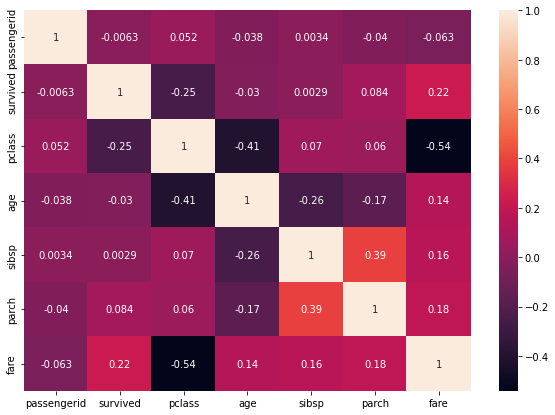

In [359]:
plt.figure(figsize=(10,7))
sns.heatmap(org_train.corr(),annot=True)
plt.show()

In [360]:
org_train.groupby(['gender','survived'])['survived'].count()

gender  survived
female  0            54
        1           273
male    0           516
        1            73
Name: survived, dtype: int64

In [361]:
pd.crosstab(org_train.pclass,org_train.survived,margins=True).style.background_gradient(cmap='summer_r')

survived,0,1,All
pclass,,,
1,96,131,227
2,118,76,194
3,356,139,495
All,570,346,916


# Missing Value Check

##### org_train heatmap

<AxesSubplot:>

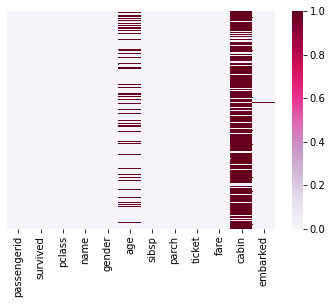

In [363]:
sns.heatmap(org_train.isnull(), yticklabels=False, cbar=True, cmap="PuRd")

##### org_test heatmap

<AxesSubplot:>

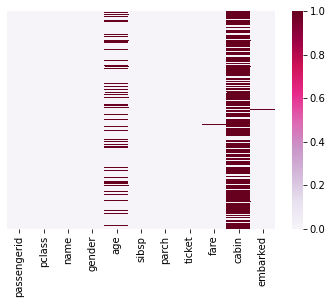

In [364]:
sns.heatmap(org_test.isnull(), yticklabels=False, cbar=True, cmap="PuRd")

##### org_train null check

In [365]:
org_train.isnull().sum()

passengerid      0
survived         0
pclass           0
name             0
gender           0
age            180
sibsp            0
parch            0
ticket           0
fare             0
cabin          718
embarked         1
dtype: int64

##### org_test null check

In [366]:
org_test.isnull().sum()

passengerid      0
pclass           0
name             0
gender           0
age             83
sibsp            0
parch            0
ticket           0
fare             1
cabin          296
embarked         1
dtype: int64

# Filling Missing Value

In [367]:
fill_train = org_train
fill_test = org_test

##### drop 'cabin' column

In [368]:
fill_train = fill_train.drop(['cabin'], axis =1)
fill_test = fill_test.drop(['cabin'], axis =1)

##### Extract Data to fill

In [369]:
# age
age_mean = fill_train['age'].mean()
# embarked
embarked_mode = fill_train['embarked'].mode().values[0]

age_mean, embarked_mode

(29.69836956521739, 'S')

In [370]:
# fare
def fare_mean_by_pclass(pclass):
    return fill_train.groupby('pclass').agg({"fare":"mean"}).values[pclass-1]

fare_mean_by_pclass(1), fare_mean_by_pclass(2), fare_mean_by_pclass(3)

(array([83.74561322]), array([20.38803608]), array([13.56636283]))

In [371]:
fill_train.isnull().sum()

passengerid      0
survived         0
pclass           0
name             0
gender           0
age            180
sibsp            0
parch            0
ticket           0
fare             0
embarked         1
dtype: int64

##### Fill with Extracted Data

In [372]:
# fill age
fill_train['age'].fillna(age_mean, inplace=True)
fill_test['age'].fillna(age_mean, inplace=True)

# fill embarked
fill_train['embarked'].fillna(embarked_mode, inplace=True)
fill_test['embarked'].fillna(embarked_mode, inplace=True)

# fill fare
fill_train['fare'].fillna(lambda x:fare_mean_by_pclass(x['pclass']), inplace=True)
fill_test['fare'].fillna(lambda x:fare_mean_by_pclass(x['pclass']), inplace=True)

In [373]:
fill_train.isnull().sum().sum(), fill_test.isnull().sum().sum()

(0, 0)

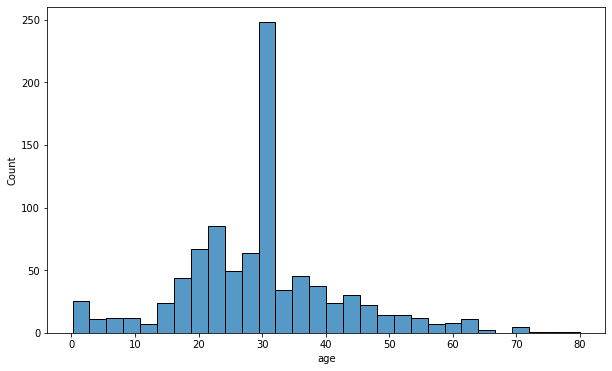

In [374]:
plt.figure(figsize=(10,6))
sns.histplot(fill_train['age'])
plt.show()

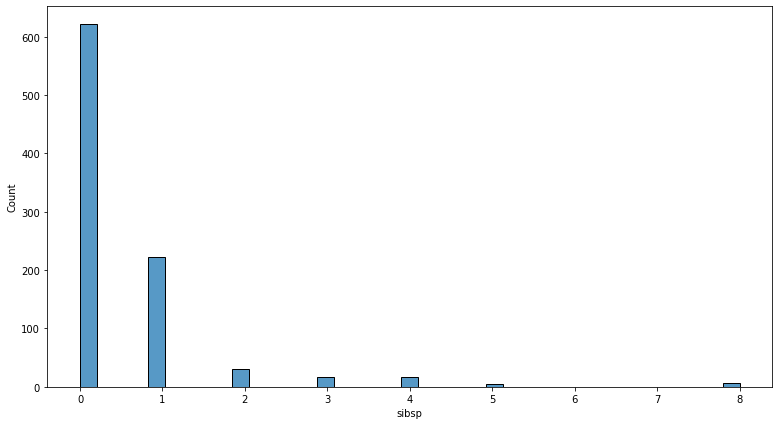

In [375]:
plt.figure(figsize=(13,7))
sns.histplot(fill_train['sibsp'])
plt.show()

<ipython-input-378-1a9e4709b607>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(fill_train.corr(),annot=True)


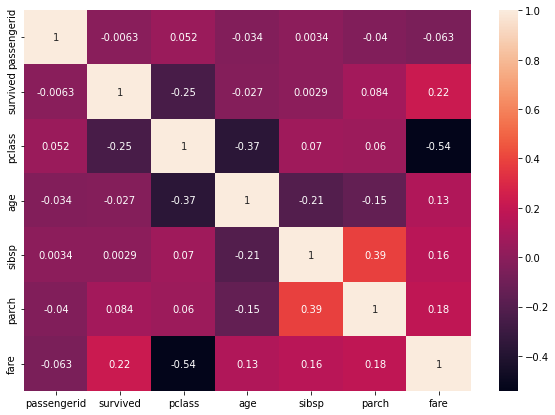

In [378]:
plt.figure(figsize=(10,7))
sns.heatmap(fill_train.corr(),annot=True)
plt.show()

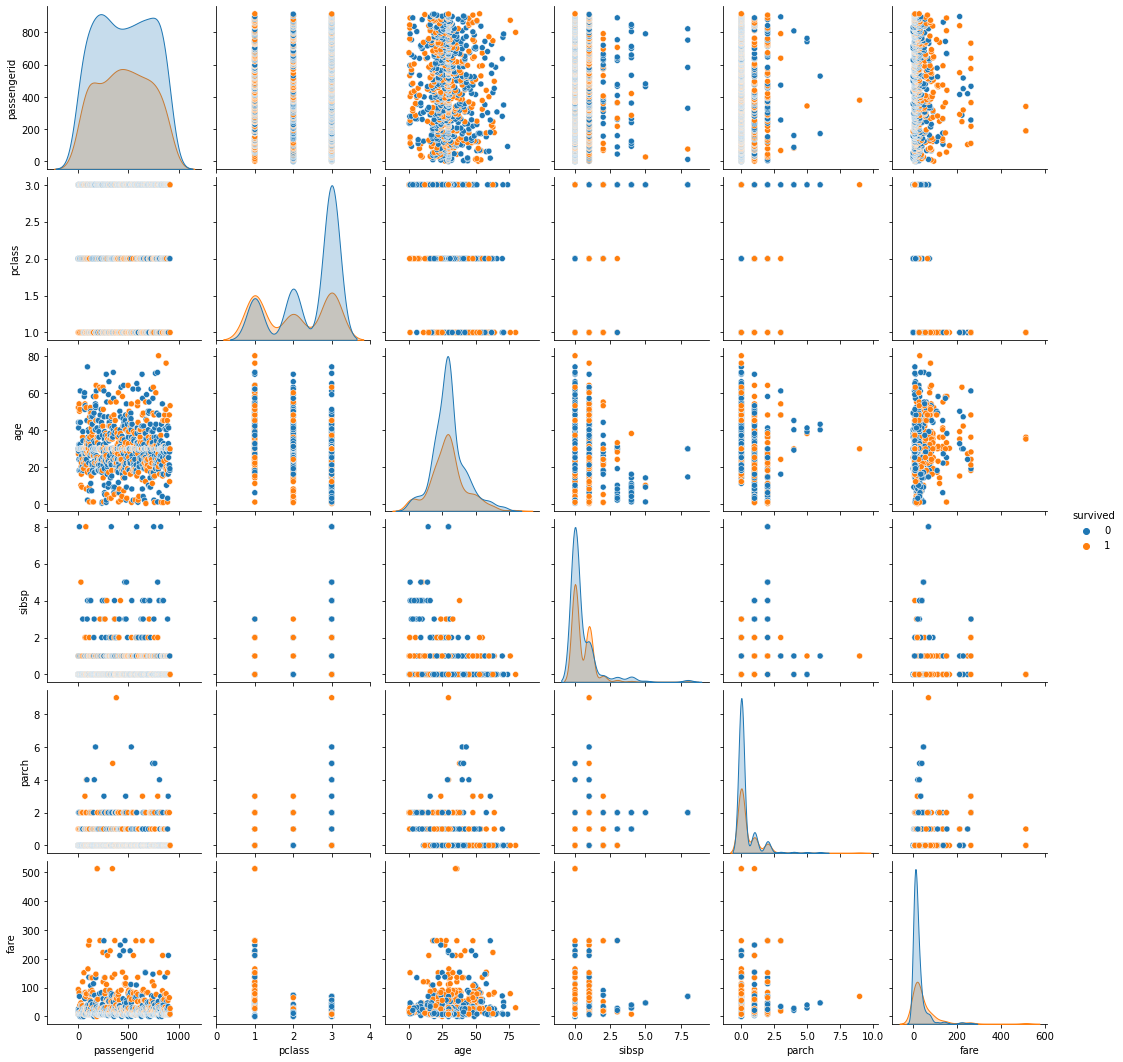

In [19]:
sns.pairplot(hue='survived',data=fill_train)
plt.show()

# Midterm check

In [379]:
fill_train.shape, fill_test.shape

((916, 11), (393, 10))

In [380]:
fill_train.info(), fill_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  916 non-null    int64  
 1   survived     916 non-null    int64  
 2   pclass       916 non-null    int64  
 3   name         916 non-null    object 
 4   gender       916 non-null    object 
 5   age          916 non-null    float64
 6   sibsp        916 non-null    int64  
 7   parch        916 non-null    int64  
 8   ticket       916 non-null    object 
 9   fare         916 non-null    float64
 10  embarked     916 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 78.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  393 non-null    int64  
 1   pclass       393 non-null    int64  
 2   name    

(None, None)

In [381]:
fill_train.head()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,29.69837,0,0,SC/PARIS 2159,12.8750,S
1,1,0,3,"Henry, Miss. Delia",female,29.69837,0,0,382649,7.7500,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.00000,1,1,12749,93.5000,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.00000,0,0,350043,7.7958,S
4,4,0,2,"Hold, Mr. Stephen",male,44.00000,1,0,26707,26.0000,S


In [23]:
fill_test.head()

,passengerid,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,916,3,"McGowan, Miss. Anna ""Annie""",female,15.00000,0,0,330923,8.0292,NaN,Q
1,917,2,"Pinsky, Mrs. (Rosa)",female,32.00000,0,0,234604,13.0,NaN,S
2,918,3,"McCarthy, Miss. Catherine Katie""""",female,29.69837,0,0,383123,7.75,NaN,Q
3,919,3,"Franklin, Mr. Charles (Charles Fardon)",male,29.69837,0,0,SOTON/O.Q. 3101314,7.25,NaN,S
4,920,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.00000,1,1,36928,164.8667,NaN,S


# EDA - Preprocessing

In [382]:
eda_train = fill_train
eda_test = fill_test

In [383]:
eda_train.head()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,29.69837,0,0,SC/PARIS 2159,12.8750,S
1,1,0,3,"Henry, Miss. Delia",female,29.69837,0,0,382649,7.7500,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.00000,1,1,12749,93.5000,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.00000,0,0,350043,7.7958,S
4,4,0,2,"Hold, Mr. Stephen",male,44.00000,1,0,26707,26.0000,S


##### Reform 'gender' column

In [384]:
gender_mapping = {
    'male': 0, 
    "female": 1
}

eda_train["gender"] = eda_train["gender"].map(gender_mapping)
eda_test["gender"] = eda_test["gender"].map(gender_mapping)

##### Add 'designation' column

In [385]:
dict_designation = {
    'Mr.': 11, # '남성'
    'Master.': 12, #'남성'
    'Sir.': 13, #'남성'
    'Miss.': 21, #'미혼 여성'
    'Mrs.': 22, #'기혼 여성'
    'Ms.': 23, #'미혼/기혼 여성'
    'Lady.': 24, # '숙녀'
    'Mlle.': 25, # '아가씨'
    'Dona.': 26,
    # 직업
    'Dr.': 30, # '의사'
    'Rev.': 31, # '목사'
    'Major.': 32, # '계급'
    'Don.': 33, # '교수'
    'Col.': 34, # '군인'
    'Capt.': 35, # '군인'
    # 귀족
    'Mme.': 40, # '영부인'
    'Countess.': 41, # '백작부인'
    'Jonkheer.': 42 # '귀족'
}

def add_designation(name): # 호칭 함수
    designation = "unknown"
    for key in dict_designation.keys():
        if key in name:
            designation = dict_designation[key]
            break
    return designation

eda_train['designation'] = eda_train['name'].map(lambda x: add_designation(x))
eda_test['designation'] = eda_test['name'].map(lambda x: add_designation(x))

##### Reform 'embarked' column

In [386]:
embarked_mapping = {"S": 1, "C": 2, "Q": 3 }

eda_train["embarked"] = eda_train["embarked"].map(embarked_mapping)
eda_test["embarked"] = eda_test["embarked"].map(embarked_mapping)

##### Add 'sub_age' column

In [387]:
eda_train['sub_age'] = eda_train['age'].map(lambda x: x//10)
eda_test['sub_age'] = eda_test['age'].map(lambda x: x//10)

##### Add 'survived_by_pclass' and 'len_sibsp_by_pclass' and 'len_parch_by_pclass' column

In [455]:
agg_dict = {"survived" : "mean", "sibsp" : "nunique", "parch" : "nunique"}

df_groupby = eda_train.groupby("pclass").agg(agg_dict).reset_index()
df_groupby.rename(columns = {'survived' : 'survived_by_pclass', 
                             'sibsp' : 'len_sibsp_by_pclass', 
                             'parch' : 'len_parch_by_pclass'}, inplace = True)
df_groupby

,pclass,survived_by_pclass,len_sibsp_by_pclass,len_parch_by_pclass
0,1,0.577093,4,4
1,2,0.391753,4,4
2,3,0.280808,7,8


In [389]:
print(f'before: {eda_train.shape}')

eda_train = pd.merge(eda_train, 
                     df_groupby,
                     how="left",
                     on="pclass") 
eda_test = pd.merge(eda_test,
                    df_groupby,
                    how="left",
                    on="pclass") 

print(f'after: {eda_train.shape}')

before: (916, 13)
after: (916, 16)


##### Add Age Group

- 영유아 : 0~17
- 아 동 : 6~12
- 청소년 : 13~18
- 청년  : 19~29
- 중년  : 30~49
- 장년  : 50~64
- 노년  : 65~

In [390]:
age_range = [0, 5, 12, 18, 29, 49, 64, 100]
age_labels = ["bady", "child", "teenager", "adult", "middle", "senior", "super-elderly"]

eda_train['age_group'] = pd.cut(eda_train['age'], age_range, labels=age_labels)
eda_test['age_group'] = pd.cut(eda_test['age'], age_range, labels=age_labels)

In [391]:
age_mappings = {
    "bady" : 1, 
    "child" : 2,
    "teenager" : 3,
    "adult" : 4,
    "middle" : 5,
    "senior" : 6,
    "super-elderly" : 7
}

eda_train['age_group'] = eda_train['age_group'].map(age_mappings)
eda_test['age_group'] = eda_test['age_group'].map(age_mappings)

In [392]:
eda_train[eda_train['age_group'].isnull()]

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,embarked,designation,sub_age,survived_by_pclass,len_sibsp_by_pclass,len_parch_by_pclass,age_group


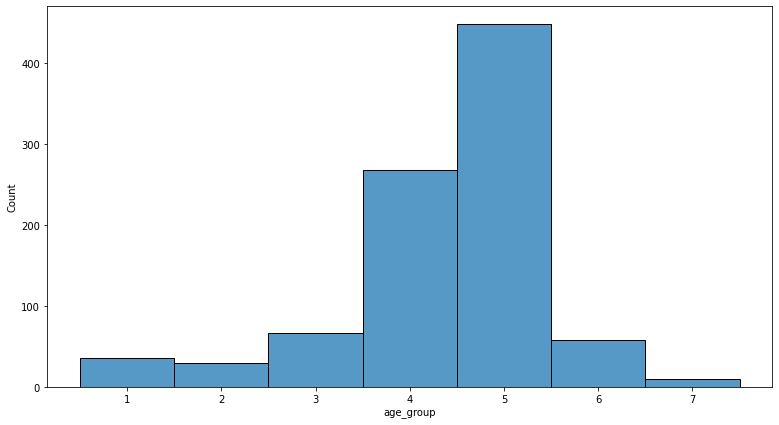

In [393]:
plt.figure(figsize=(13,7))
sns.histplot(eda_train['age_group'])
plt.show()

### Un necessary columns removed
##### Remove 'name' and 'ticket' and 'age' column

In [394]:
eda_train = eda_train.drop(['name'], axis=1)
eda_test = eda_test.drop(['name'], axis=1)

In [395]:
eda_train = eda_train.drop(['age'], axis=1)
eda_test = eda_test.drop(['age'], axis=1)

In [396]:
eda_train = eda_train.drop(['ticket'], axis=1)
eda_test = eda_test.drop(['ticket'], axis=1)

In [397]:
eda_train.head()

,passengerid,survived,pclass,gender,sibsp,parch,fare,embarked,designation,sub_age,survived_by_pclass,len_sibsp_by_pclass,len_parch_by_pclass,age_group
0,0,0,2,0,0,0,12.8750,1,11,2.0,0.391753,4,4,5
1,1,0,3,1,0,0,7.7500,3,21,2.0,0.280808,7,8,5
2,2,1,1,1,1,1,93.5000,1,22,5.0,0.577093,4,4,6
3,3,1,3,0,0,0,7.7958,1,11,2.0,0.280808,7,8,4
4,4,0,2,0,1,0,26.0000,1,11,4.0,0.391753,4,4,5


In [398]:
eda_train.columns

Index(['passengerid', 'survived', 'pclass', 'gender', 'sibsp', 'parch', 'fare',
       'embarked', 'designation', 'sub_age', 'survived_by_pclass',
       'len_sibsp_by_pclass', 'len_parch_by_pclass', 'age_group'],
      dtype='object')

In [429]:
cols = ['pclass', 'gender', 'sibsp', 'parch','designation', #'fare',
        'survived_by_pclass', 'survived_by_pclass', 'len_parch_by_pclass']


X = eda_train[cols]
y = eda_train['survived'] # target

test = eda_test[cols+['passengerid']]

X.shape, y.shape, test.shape

((916, 8), (916,), (393, 9))

In [430]:
eda_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 916 entries, 0 to 915
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   passengerid          916 non-null    int64   
 1   survived             916 non-null    int64   
 2   pclass               916 non-null    int64   
 3   gender               916 non-null    int64   
 4   sibsp                916 non-null    int64   
 5   parch                916 non-null    int64   
 6   fare                 916 non-null    float64 
 7   embarked             916 non-null    int64   
 8   designation          916 non-null    int64   
 9   sub_age              916 non-null    float64 
 10  survived_by_pclass   916 non-null    float64 
 11  len_sibsp_by_pclass  916 non-null    int64   
 12  len_parch_by_pclass  916 non-null    int64   
 13  age_group            916 non-null    category
dtypes: category(1), float64(3), int64(10)
memory usage: 101.4 KB


<ipython-input-431-48f2de08cb85>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(eda_train.corr(), vmin = -1, vmax = 1, annot=True, linewidths=0.01, cmap='Reds')


<AxesSubplot:>

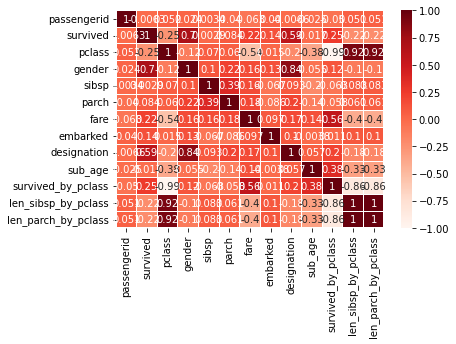

In [431]:
sns.heatmap(eda_train.corr(), vmin = -1, vmax = 1, annot=True, linewidths=0.01, cmap='Reds')

### Model Set

##### Import Library

In [432]:
from sklearn.model_selection import train_test_split

##### Split dataset

In [433]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    stratify = eda_train['survived'],
    random_state = args.random_state
)

In [434]:
X_train.shape, X_test.shape, test.shape

((732, 8), (184, 8), (393, 9))

In [435]:
X_train.isnull().sum().sum(), X_test.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0, 0)

In [436]:
test.set_index(['passengerid'], inplace=True)  

print(f'{test.shape}')
test.head()

(393, 8)


,pclass,gender,sibsp,parch,designation,survived_by_pclass,survived_by_pclass,len_parch_by_pclass
passengerid,,,,,,,,
916,3,1,0,0,21,0.280808,0.280808,8
917,2,1,0,0,22,0.391753,0.391753,4
918,3,1,0,0,21,0.280808,0.280808,8
919,3,0,0,0,11,0.280808,0.280808,8
920,1,1,1,1,22,0.577093,0.577093,4


### DecisionTree

### auc test

1) 0.8391604010025062  
cols = ['pclass', 'gender', 'sibsp', 'parch','designation'] 

2) 0.774561403508772  
cols = ['pclass', 'gender', 'sibsp', 'parch','designation', 'sub_age'] 

3) 0.7929197994987467  
cols = ['pclass', 'gender', 'sibsp', 'parch','designation', 'fare', 'embarked']  

4) 0.8391604010025062  
cols = ['pclass', 'gender', 'sibsp', 'parch','designation', 'survived_by_pclass']  

5) 0.8391604010025062  
cols = ['pclass', 'gender', 'sibsp', 'parch','designation', 'survived_by_pclass', 'survived_by_pclass']  
       
6) 0.8391604010025062  
cols = ['pclass', 'gender', 'sibsp', 'parch','designation', 
        'survived_by_pclass', 'survived_by_pclass', 'len_parch_by_pclass']

7) 0.8102756892230576  
cols = ['pclass', 'gender', 'sibsp', 'parch', 'fare', 'designation', 
        'survived_by_pclass', 'survived_by_pclass', 'len_parch_by_pclass']
        
8) 0.8102756892230576  
cols = ['pclass', 'gender', 'sibsp', 'parch', 'fare', 'designation', 
        'survived_by_pclass', 'survived_by_pclass', 'len_parch_by_pclass']  

In [437]:
from sklearn.tree import DecisionTreeClassifier

deicisiontree = DecisionTreeClassifier(random_state=args.random_state)
deicisiontree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=21)

In [438]:
from sklearn.metrics import roc_curve, auc 

pred = deicisiontree.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, pred)

auc(fpr, tpr)

0.8391604010025062

##### Test Prediction

In [439]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393 entries, 916 to 1308
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pclass               393 non-null    int64  
 1   gender               393 non-null    int64  
 2   sibsp                393 non-null    int64  
 3   parch                393 non-null    int64  
 4   designation          393 non-null    int64  
 5   survived_by_pclass   393 non-null    float64
 6   survived_by_pclass   393 non-null    float64
 7   len_parch_by_pclass  393 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 27.6 KB


In [440]:
test_pred = deicisiontree.predict_proba(test)[:, 1]
test_pred.shape

(393,)

### Random Forest

### acu test

1) 0.8386591478696742  
cols = ['pclass', 'gender', 'sibsp', 'parch','designation', 'age_group',
        'survived_by_pclass', 'survived_by_pclass', 'len_parch_by_pclass']

In [441]:
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier(random_state=args.random_state)
randomforest.fit(X_train, y_train)

# y_pred = randomforest.predict(x_val)
# acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
# print(acc_randomforest)

RandomForestClassifier(random_state=21)

In [442]:
from sklearn.metrics import roc_curve, auc 

pred = randomforest.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, pred)

auc(fpr, tpr)

0.8721804511278196

In [443]:
test_pred = randomforest.predict_proba(test)[:, 1]
test_pred.shape

(393,)

In [444]:
test_pred[:3]

array([0.76669714, 0.91362721, 0.76669714])

In [445]:
submission = pd.read_csv(args.submission_csv)
print(f'{submission.shape}')
submission.head()

(393, 2)


,passengerid,survived
0,916,0.5
1,917,0.5
2,918,0.5
3,919,0.5
4,920,0.5


In [446]:
submission['survived'] = test_pred
submission.head()

,passengerid,survived
0,916,0.766697
1,917,0.913627
2,918,0.766697
3,919,0.085451
4,920,1.000000


In [ ]:
submission.to_csv(args.submission_csv_230220_t1, header=True, index=False)

### Gradient Boosting Classifier

### acu test

1) 0.8566416040100251  
cols = ['pclass', 'gender', 'sibsp', 'parch','designation', 'age_group',
        'survived_by_pclass', 'survived_by_pclass', 'len_parch_by_pclass']  

In [447]:
from sklearn.ensemble import GradientBoostingClassifier

gradientboosting = GradientBoostingClassifier()
gradientboosting.fit(X_train, y_train)

# y_pred = gbk.predict(x_val)
# acc_gbk = round(accuracy_score(y_pred, y_val) * 100, 2)
# print(acc_gbk)

GradientBoostingClassifier()

In [448]:
from sklearn.metrics import roc_curve, auc 

pred = gradientboosting.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, pred)

auc(fpr, tpr)

0.8647869674185464

In [449]:
test_pred = randomforest.predict_proba(test)[:, 1]
test_pred.shape

(393,)

### Logistic Regression

In [450]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

logregression = LogisticRegression()
logregression.fit(X_train, y_train)
# y_pred = logreg.predict(x_val)
# acc_logreg = round(accuracy_score(y_pred,y_val)*100,2)
# acc_logreg

LogisticRegression()

In [451]:
from sklearn.metrics import roc_curve, auc 

pred = logregression.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, pred)

auc(fpr, tpr)

0.8666666666666666

In [452]:
test_pred = logregression.predict_proba(test)[:, 1]
test_pred.shape

(393,)

In [453]:
from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score

rf_pred = logregression.predict(X_test)
lr_pred = logregression.predict(X_test)

print (f"ACCURACY  : RF={accuracy_score(y_test,rf_pred):.3f}, LR={accuracy_score(y_test,lr_pred):.3f}")
print (f"F1-SCORE  : RF={f1_score(y_test,rf_pred,average='macro'):.3f}, LR={f1_score(y_test,lr_pred,average='macro'):.3f}")
print (f"PRECISION : RF={precision_score(y_test,rf_pred,average='macro'):.3f}, LR={precision_score(y_test,lr_pred,average='macro'):.3f}")
print (f"RECALL    : RF={recall_score(y_test,rf_pred,average='macro'):.3f}, LR={recall_score(y_test,lr_pred,average='macro'):.3f}")

ACCURACY  : RF=0.864, LR=0.864
F1-SCORE  : RF=0.852, LR=0.852
PRECISION : RF=0.865, LR=0.865
RECALL    : RF=0.843, LR=0.843


In [454]:
lr_pred = lr_pred.astype(int)
accuracy_score(y_test, lr_pred)*100

86.41304347826086